# Predicting StackOverflow Answer Scores with Machine Learning

**Donald Isaac**

12/20/2021



## Abstract

Source code quality is an important yet vague and subjective property. It may refer to performance, maintainability, readability, etc. This project attempts to measure this fuzzy construct using upvotes on stack overflow answers as a proxy. A variety of regression models are tested, including Random Forests and [Long-Short-Term-Memory](https://www.bioinf.jku.at/publications/older/2604.pdf) (LSTM) RNNs.

## Table of Contents

1. [Introduction](#Introduction)
2. [Preparation](#Preparation)
3. [Training the Models](#My-Machine-Learns-But-I-Don't)
4. [Conclusion](#Conclusion)

# Introduction

Source code quality management is an important and active area of research and engineering efforts. Automated tools such as linters, code smell detectors, and other static analysis systems are often used in Continuous Integration (CI) pipelines to manage code quality during development.

These tools usually operate on Abstract Syntax Trees (ASTs) and enforce a fixed, limited set of rules. As such, they tend to be limited in scope, detection ability, and adaptability. For example, linters tend focus their scope on syntax and style. New style rules are implemented as functions that analyze a program's AST and are then imported via a configuration file. This is a time consuming and inflexible process.

An ideal tool would be able to detect patterns in source code that make it "good" or "bad". It would be able to detect quality over a broad range of domains, such as readability, maintainability, and performance. It would also be able to adapt its definitions of quality over time, learning on new code examples.

This project attempts to find a machine learning model capable of determining an understanding of code quality by scraping code snippets from over 200k Stack Overflow answers and using their scores as a proxy metric. I focus on code written in C to reduce cross-language variance.

## Setup

This section details the runtime setup and environment I used with the goal of promoting reproducibility. If you are not interested in setup details, you should skip to the [preparation section](#preparation).

This code was run with Google Colab on a High-RAM + GPU runtime using Python 3.7.12. I used TensorFlow + Keras for constructing Neural Networks and SKLearn for all other machine learning tasks.


In [ ]:
# Check Python and OS versions
!python --version
!echo ""

!uname -msrv
!echo ""

!lsb_release -a


### Check Cuda/GPU/cuDNN Availability

In [ ]:
# Check CUDA/cuDNN Version
!nvcc -V && which nvcc

In [ ]:
# Check GPU
!nvidia-smi

### Install Extra Packages

In [ ]:
%matplotlib inline
!pip install -q dnspython python-dotenv pymongo[srv] pymongo keras-tuner

### Import Packages

In [1]:
# Standard library
import os
import math
import subprocess
from typing import Generator, List, Dict, Union, Tuple, Type, TypeVar, NewType, Any
from typing_extensions import TypedDict, Literal
import time
import sys
from urllib.parse import quote_plus

# Data management primitives
import numpy as np
from numpy.random import SeedSequence, RandomState, seed
import pandas as pd

# Neural network tools
import tensorflow as tf
import keras as k
from tensorflow import keras
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras_tuner as kt

# Patch joblib import - https://stackoverflow.com/questions/64509977/modulenotfounderror-no-module-named-sklearn-externals-joblib
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

# Random Forest tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Data loading and preprocessing
from dotenv import load_dotenv
from pymongo import MongoClient
from pycparser import CParser, c_lexer, parse_file
from pycparser.c_lexer import CLexer
from pycparser.ply.lex import LexToken

# Visualization
import matplotlib.pyplot as plt


In [2]:
# https://primes.utm.edu/curios/page.php/2147483647.html
seeder = SeedSequence(2147483647)
rs = RandomState(seeder.generate_state(1))
seed(seeder.generate_state(1))
random_state = int(seeder.generate_state(1)[0]) 

In [3]:
print('\nAvailable devices:')
print("\n".join(map(str, tf.config.list_physical_devices())))
print(f'\nGPU device name: "{tf.test.gpu_device_name()}"')


Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU device name: "/device:GPU:0"


### Load Environment Variables

This step loads credentials and the mongo connection URL from a `.env` file.

In [4]:
load_dotenv()

True

### Establish the Database Connection

In [5]:
def connect_to_mongo():
    """
    Connects to MongoDB and gets the database containing StackOverflow
    question and answer data.

    """

    # A MongoDB connection string _must_ be provided
    mongo_uri = os.getenv('MONGO_URI')
    if not mongo_uri:
        raise Exception('MONGO_URI not set')

    # URI may either be a fully usable mongo connection string, or a printf-style string
    # where the username and password are specified as %s and %s respectively
    # e.g. mongodb+srv://%s:%s@mongodb.mydomain.com:27017/someDatabase
    # See: 
    #   https://pymongo.readthedocs.io/en/stable/api/pymongo/mongo_client.html#pymongo.mongo_client.MongoClient
    #   https://docs.mongodb.com/manual/reference/connection-string/
    user = os.getenv('MONGO_USERNAME') or os.getenv('MONGO_PUBLIC_KEY')
    pw = os.getenv('MONGO_PASSWORD') or os.getenv('MONGO_PRIVATE_KEY')

    if user and pw:
        mongo_uri = mongo_uri % ( quote_plus(user), quote_plus(pw))
    else:
        assert not user and not pw, 'MONGO_USERNAME and MONGO_PASSWORD must both be set or both be unset'

    client = MongoClient(mongo_uri, tls=True)
    return client['stackOverflowDB']

db = connect_to_mongo()

# Preparation

## Utilties

Below are some utilities that are used throughout the code, but
mostly during preprocessing.


The utilities include classes for [lexing](https://en.wikipedia.org/wiki/Lexical_analysis) and [parsing](https://en.wikipedia.org/wiki/Parsing#Computer_languages) C code. The lexer is used to tokenize code snippets. Because valid C code is well formed and follows a well-defined grammar, we don't need to perform tokinization with a transformer model such as [BERT](https://arxiv.org/abs/1810.04805). The parser is not used in this project, but may be useful during future research for warning classification tasks.

This has the added benefit of erroring if a code snippet has invalid syntax, allowing me to better clean the dataset. Questions were selected by tags (_i.e. "hey StackOverflow, get me all recent questions that have been tagged as `c`"_). This doesn't guarantee that snippets are _all_ C code; for example, they may be a shell command to compile C, or they may be C++.

This cleaning is not complete. For example, the lexer would be able to tokenize the below C snippet, marking it as valid, even though it clearly is not.

```c
} int (int argc, char ** argv) { main ;
```

This is okay as we are still able to compare these snippets to well-formed ones. It is possible that malformed snippets score lower than well formed ones - the machine learning models should be able to learn this for themselves.

In [8]:
# List of potential programs for parsing C/C++
# 'cc' is intentionally not included
_programs = ['gcc', 'g++', 'c++', 'clang', 'clang++']

class ParserOutput(TypedDict):
    success: bool
    warnings: List[str]
    errors: List[str]

class SnippetCleaner:
    """
    A utility for parsing C tokens. It uses a c/c++ compiler if one is available,
    otherwise it falls bacy to pycparser.
    """

    def __init__(self, **kwargs):
        self.verbose: bool = kwargs.get('verbose', False)

        # self.cc = self.cpp = CParser()
        cc_override = kwargs.get('cc_override', kwargs.get('override', None))
        cpp_override = kwargs.get('cpp_override', kwargs.get('override', None))
        self._init_parsers(cc_override, cpp_override)

    def _init_parsers(self, cc_override=None, cpp_override=None):
        """
        TODO: Use this if pycparser doesn't come through
        """
        # Dict of all available C/C++ compiler programs.
        ccs = self._get_available_cc_progs()

        # Determine which C parser to use.
        if cc_override:
            assert cc_override in ccs
            self.cc: Union[str, CParser]  = cc_override
        elif ccs['gcc']:
            self.cc = 'gcc'
        elif ccs['clang']:
            self.cc = 'clang'
        else:
            self.cc = CParser()

        # Determine which C++ parser to use.
        if cpp_override:
            assert cpp_override in ccs
            self.cpp: Union[str, CParser] = cpp_override
        elif ccs['g++']:
            self.cpp = 'g++'
        elif ccs['clang++']:
            self.cpp = 'clang++'
        elif ccs['c++']:
            self.cpp = 'c++'
        elif ccs['gcc']:  # Fallback to gcc (TODO: is this okay to do?)
            self.cpp = 'gcc'
        else:
            self.cpp = CParser()

    def _get_available_cc_progs(self) -> Dict[str, bool]:
        """
        Checks for available C/C++ compiler programs.
        Returns a dictionary containing the names of the available C/C++ compiler, 
        and a boolean indicating if the compiler is available.
        """

        result: dict = {}
        for prog in _programs:
            try:
                completed_prog = subprocess.run(
                    [prog, '--version'], stdout=None, stderr=None)
                result[prog] = completed_prog.returncode == 0
            except:
                result[prog] = False

        return result

    def _parse_cc_output(self, output: Union[subprocess.CalledProcessError, subprocess.CompletedProcess]) -> ParserOutput:
        """
        """
        stdout: str = output.stdout.decode('utf-8') if output.stdout is not None else ''
        stderr: str = output.stderr.decode('utf-8') if output.stderr is not None else ''
        logs = stdout.split('\n') + stderr.split('\n')

        errors = list(filter(lambda err: 'error' in err, logs))
        warnings = list(filter(lambda warn: 'warn' in warn, logs))

        success = len(errors) == 0 and (output.returncode == 0 if isinstance(output, subprocess.CompletedProcess) else False)
        return {
            'success': success,
            'errors': errors,
            'warnings': warnings
        }

    def _check_c_snippet(self, snippet: str, name='') -> ParserOutput:
        """
        Checks if the code snippet is valid C code.
        TODO
        """

        # Analyze the code snippet with gcc or clang frontend
        if self.cc == 'gcc' or self.cc == 'clang':
            prog: Literal['gcc', 'clang'] = self.cc

            # Run gcc/clang on the snippet
            try:
                status = subprocess.run(
                    [prog, '--analyze', '--analyzer-output', 'sarif', '-x', 'c', '-'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, input=snippet.encode(), check=True)
                return self._parse_cc_output(status)
                # return {'success': True, 'warnings': [], 'errors': []}

            # Warnings or errors occurred, parse the output
            except subprocess.CalledProcessError as e:
                return self._parse_cc_output(e)

            except subprocess.TimeoutExpired as e:
                if self.verbose:
                    print(f'Timeout: {e}')
                return {'success': False, 'errors': [], 'warnings': []}

        # Use pycparser to parse the code snippet and check if it is valid C code
        elif isinstance(self.cc, CParser):
            try:
                parser: CParser = self.cc
                parser.parse(snippet, name, 1 if self.verbose else 0)
                return {'success': True, 'warnings': [], 'errors': []}

            except Exception as e:
                return { 'success': False, 'errors': [str(e)], 'warnings': [] }

        else:
            raise TypeError(f'Unknown compiler: {self.cc}')

    # Parses a code snippet and checks if it is valid C code. If the check fails,
    # it checks if the snippet is valid C++ code. Returns a tuple containing
    # two booleans, the first one indicating if the code snippet is valid C code,
    # the second one indicating if the code snippet is valid C++ code.
    def parse(self, snippet: str, name: str = '') -> Tuple[bool, bool]:
        c_parse_result = self._check_c_snippet(snippet, name)
        if self.verbose:
            print(f'Errors: {c_parse_result["errors"]}')
            print(f'Warnings: {c_parse_result["warnings"]}')

        # TODO: Check if the code snippet is valid C++ code
        return (c_parse_result['success'], False)

In [9]:
# All possible states the SnippetLexer may be in
LexerStatus = Literal['pending', 'running', 'error', 'success']

class SnippetLexer:
    """
    Turns a C code snippet into a list of tokens. Uses pycparser for lexing.
    """

    def __init__(self):
        self._lexer = CLexer(error_func=self._on_error, on_lbrace_func=self._on_lbrace,
                             on_rbrace_func=self._on_rbrace, type_lookup_func=self._type_lookup)
        # 'pending', 'running', 'error', 'success'
        self.status: LexerStatus = 'pending'
        self.errors: List[str] = [] 
        self.brace_depth = 0
        self._is_built = False

    def lex(self, snippet: str, **kwargs) -> Tuple[List[LexToken], LexerStatus]:
        """
        Lexes a code snippet and returns a tuple containing the lexed snippet and
        the lexer's status. The status can be 'pending', 'running', 'error', or 'success'.

        If the lexer's status is 'error', the errors list will contain a list of
        error messages.
        """
        
        self.reset()
        toks: List[LexToken] = []

        self.status = 'running'

        if not self._is_built:
          self._lexer.build(**kwargs)
          self._is_built = True

        self._lexer.input(snippet)
        # self._lexer.token()

        while True:
            tok = self._lexer.token()
            if not tok:
                break
            toks.append(tok)

        # Check for hanging open braces
        if self.brace_depth > 0:
            self.status = 'error'
            self.errors.append('Unbalanced braces')

        self.status = 'success' if self.status == 'running' else self.status
        return (toks, self.status)

    def reset(self):
        """
        Resets the lexer's internal state after lexing a snippet.
        """

        self.status = 'pending'
        self.errors = []
        self.brace_depth = 0

    @property
    def tokens(self):
        """
        Gets a list of all possible C tokens. This is used as the vocabulary
        during processing/training.
        """
        
        if not self._is_built:
            raise Exception('Cannot get tokens before lexer has been built')
      
        return self._lexer.tokens

    def _type_lookup(self, token):
        return True

    def _on_lbrace(self):
        self.brace_depth += 1

    def _on_rbrace(self):
        self.brace_depth -= 1
        if self.brace_depth < 0:
            self.status = 'error'
            self.errors.append('Unbalanced braces')

    def _on_error(self, msg, _line, _column):
        self.status = 'error'
        self.errors.append(msg)

## Getting the Data

To obtain the data, I used a combination of the StackOverflow API and web scraping. I searched for questions tagged with `c`, sorting chronologically.
Questions with a score of 0 or lower were filtered out.

Using the link to the
question page, I then scraped all answeres from each question. Code snippets
were extracted from all `pre` tags, then joined together into a single block
of text. Pre tags were specifically used to only obtain longer code blocks,
rather than inline monospaced text. Answers with no code were discarded, and 
questions with no valid answers after filtering were also discarded. Once obtained, all data was put into a MongoDB database running on [MongoDB Atlas](https://www.mongodb.com/atlas/database).

The code used to extract question and answer data may be found [here](https://github.com/DonIsaac/cmsc320-final/blob/main/scrape/stack.py).



In all, over 118k questions and 213k answers were scraped from Stack Overflow. After filtering and cleaning, this turns into about 50k total records. Unfortunately, TensorFlow is not able to handle this much data at once, so only about 10k rows are actually used for training.

In [10]:
num_questions = db.questions.estimated_document_count()
num_answers = db.answers.estimated_document_count()

print(f'The database contains {num_questions:,} questions and {num_answers:,} answers scraped from StackOverflow.')

The database contains 118,349 questions and 213,237 answers scraped from StackOverflow.


The data stored in a normalized format - a collection for questions and a question for answers. This is great for storage, but not so much for usage.
The code below performs a left inner join on questions and restructures the
results, resulting in a single row per question. Questions with too low of
a score are also filtered out (again).

In [11]:
min_question_score = 5

def load_data():
  pipeline: List[Dict] = []
  
  # Filter out questions with low scores
  # SELECT * FROM questions WHERE score > min_question_score
  pipeline.append({'$match':
                   {'score': { '$gt': min_question_score }}})
  
  # Note that we intentionally do not add a $limit to this pipeline. We want a
  # random distribution of question scores, and because scores is indexed and 
  # we match on it, we would be selecting a slice of questions sorted by score.

  # Pick and rename fields from questions we want. Renaming avoids field
  # collisions with answer data
  pipeline.append({'$project': {
      'question_id': 1,
      'question_title': '$title',
      'question_view_count': '$view_count',
      'answer_count': 1,
      'is_answered': 1,
      'question_score': '$score'
  }})

  # Inner left join 'questions' with 'answers' on the question id
  pipeline.append({'$lookup': {
      'from': 'answers',
      'localField': '_id',
      'foreignField': 'question_id',
      'as': 'answers'
  }})

  # Answers are now stored in a list field in the question document. Unwind them
  # to create a unique document for each answer
  pipeline.append({'$unwind': '$answers'})

  # Now answers is an object field, project again to flatten the records hape
  pipeline.append({'$project': {
      # '_id': 0,
      'question_score': 1,
      'question_view_count': 1,
      'question_title': 1,
      'question_id': 1,
      'question_is_answered': '$is_answered',
      'question_has_highest_accepted_answer': '$answers.question_has_highest_accepted_answer',
      'answer_count': 1,
      'answer_score': '$answers.score',
      'answer_snippets': '$answers.snippets',
      'answer_id': '$answers._id',
      'answer_is_accepted': '$answers.is_answered',
      'answer_is_highest_scored': '$answers.is_highest_scored',
      'answer_url': '$answers.source'
  }})

  # Execute the query  
  data = db.questions.aggregate(pipeline)
  return pd.DataFrame.from_records(data, index='answer_id')

df = load_data()
print(f'Initial dataset has {len(df):,} records')

Initial dataset has 51,482 records


In [14]:
df.head()

,_id,answer_count,question_id,question_title,question_view_count,question_score,question_is_answered,question_has_highest_accepted_answer,answer_score,answer_snippets,answer_is_highest_scored,answer_url
answer_id,,,,,,,,,,,,
15197157,15192948,3,15192948,"C dynamically printf double, no loss of precis...",8839,6,True,True,9,// file: PrintFullFraction.c\n//\n// compile w...,True,https://stackoverflow.com/a/15197157
70133323,70133225,2,70133225,Using const keyword in c,68,6,True,True,3,char const const *ptr = &a;\n\npointer to cons...,False,https://stackoverflow.com/a/70133323
70133325,70133225,2,70133225,Using const keyword in c,68,6,True,True,4,static char const *const delimit_method_string...,True,https://stackoverflow.com/a/70133325
70130202,70130105,2,70130105,bit-shift right-hand operand type,75,6,True,True,1,int main()\n{\n int x = 16;\n long int y...,False,https://stackoverflow.com/a/70130202
70089860,70089766,4,70089766,How to &#39;tag&#39; a location in a C source ...,95,6,True,False,2,#include <stdio.h>\nstatic volatile int loc;\n...,False,https://stackoverflow.com/a/70089860


## Data Exploration

This section provides a bit of insight into what kind of data we have.

In [15]:
df[['question_score', 'answer_score']].describe()

,question_score,answer_score
count,51482.000000,51482.000000
mean,49.265549,14.080747
std,238.757766,69.547787
min,6.000000,-41.000000
25%,8.000000,1.000000
50%,13.000000,4.000000
75%,33.000000,11.000000
max,9598.000000,9295.000000


Most questions and answers have less than 200 scores, and most
questions have more upvotes than their answers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f981b9639d0>,
      dtype=object)

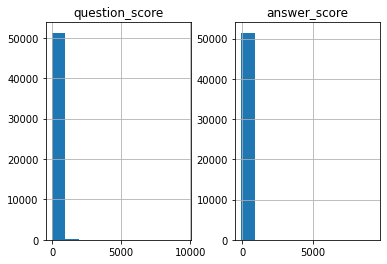

In [16]:
df[['question_score', 'answer_score']].hist()

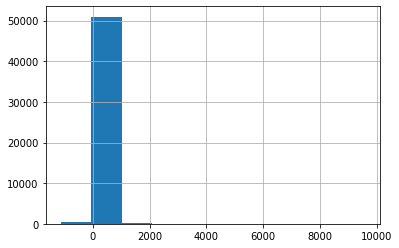

In [17]:
(df['question_score'] - df['answer_score']).hist()

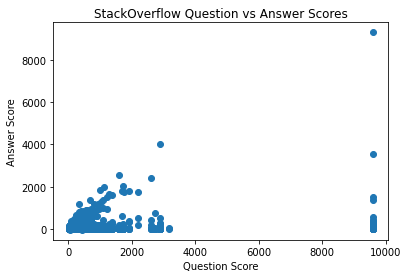

In [19]:
plt.scatter(df['question_score'],
            df['answer_score'])

plt.title('StackOverflow Question vs Answer Scores')
plt.xlabel('Question Score')
plt.ylabel('Answer Score')

plt.show()

This data is too clumped up - it's much clearer when displayed on a log scale.

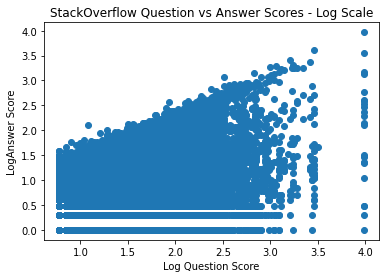

In [20]:
plt.scatter(df['question_score'].apply(np.log10),
            df['answer_score'].apply(np.log10))

plt.title('StackOverflow Question vs Answer Scores - Log Scale')
plt.xlabel('Log Question Score')
plt.ylabel('LogAnswer Score')

plt.show()

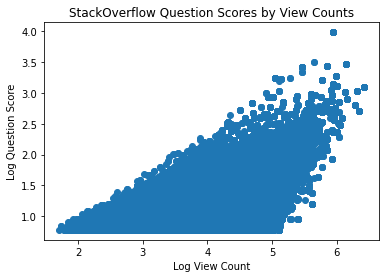

In [21]:
plt.scatter(df['question_view_count'].apply(np.log10),
            df['question_score'].apply(np.log10))

plt.title('StackOverflow Question Scores by View Counts')
plt.xlabel('Log View Count')
plt.ylabel('Log Question Score')

plt.show()

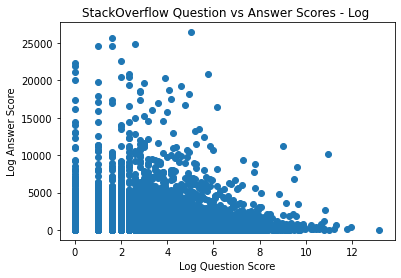

In [22]:
plt.scatter(df['answer_score'].apply(np.log2),
            df['answer_snippets'].str.strip().str.len())

plt.title('StackOverflow Question vs Answer Scores - Log ')
plt.xlabel('Log Question Score')
plt.ylabel('Log Answer Score')

plt.show()

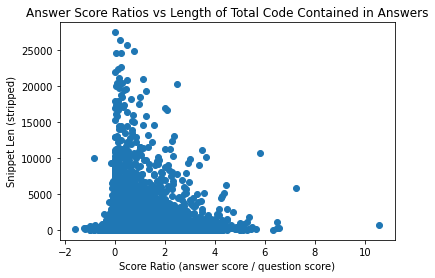

In [23]:
score_ratio = df['answer_score'] / df['question_score']
plt.scatter(score_ratio,
            df['answer_snippets'].str.strip().str.len())

plt.title('Answer Score Ratios vs Length of Total Code Contained in Answers')
plt.xlabel('Score Ratio (answer score / question score)')
plt.ylabel('Snippet Len (stripped)')

plt.show()

## Preprocessing

Before training can start, the dataset must undergo further cleaning as well as tokinization.

### Pre-Processing Hyperparameters

In [24]:
# The number of observations to train the model with. Make this none to use
# the entire dataset. Limiting the sample size makes preprocessing and training
# faster, which is beneficial for development/debugging.
dataset_size: Union[int, None] = 10_000

# The number of tokens that must be included in each feature vector. Snippets
# with more tokens will be truncated, and snippets with fewer tokens will be
# padded with zeros. (right-padded).
toks_per_seq: int = 1500

# Rows whose answer snippets have a lower length than this are discarded
min_snippet_len = 100

# Answers for questions with fewer than 1,000 views are also discarded
min_question_views = 1000

### Cleaning

In [25]:
# Remove leading/trailing whitespace from answer code
df['answer_snippets'] = df['answer_snippets'].str.strip()

# Filter out rows with fewer than `min_snippet_len` character long answer snippets
df = df[df['answer_snippets'].str.len() > min_snippet_len]

# Filter out rows whose questions had fewer than `min_question_views` views
df = df[df['question_view_count'] > min_question_views]
print(f'After filtering out undesireable entries, the dataframe has {len(df):,} rows.')

# Take a random sample of our dataset
if dataset_size is not None and len(df) > dataset_size:
  df = df.sample(dataset_size, random_state=rs)

print(f'After random sampling, the dataframe has {len(df):,} rows.')
df.head(3)

After filtering out undesireable entries, the dataframe has 33,064 rows.
After random sampling, the dataframe has 10,000 rows.


,_id,answer_count,question_id,question_title,question_view_count,question_score,question_is_answered,question_has_highest_accepted_answer,answer_score,answer_snippets,answer_is_highest_scored,answer_url
answer_id,,,,,,,,,,,,
5677564,5677347,10,5677347,Is there a better way to do C style error hand...,8380,11,True,False,3,"StatusCode FooBar(int a, int b, int c, bool* o...",False,https://stackoverflow.com/a/5677564
54540847,4826311,15,4826311,How to sort a stack using only stack operations?,56220,26,True,True,0,class Program\n{\n static void Main(string[...,False,https://stackoverflow.com/a/54540847
500017,500006,17,500006,What is the purpose of anonymous { } blocks in...,7267,42,True,True,2,"int a=25;\nint b=30;\n{ //at this point, a=25,...",False,https://stackoverflow.com/a/500017


### Reshaping

Answer scores don't just correlate to how well the snippet answers a question - they also correlate to the number of views the post has gotten. To address this, I take the ratio of the
answer's score to the question's score.

The resulting ratio is highly clumped towards just over 0, as was demonstrated during the exploration stage. To spread out the data a bit more, I apply the cube root function to the ratio. This also preserves the sign of the ratio, which may be negative if the answer has a negative score.

min: -1.170, max: 1.935, diff: 3.105


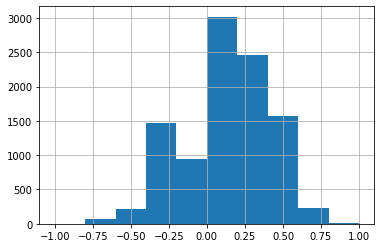

In [27]:
# This is OK because questions with zero score were filtered out during scraping
df['score_ratio'] = (df['answer_score'] / df['question_score']).apply(np.cbrt)

score_ratio_min = df['score_ratio'].min()
score_ratio_max = df['score_ratio'].max()
score_ratio_diff = score_ratio_max - score_ratio_min
print(f'min: {score_ratio_min:.3f}, max: {score_ratio_max:.3f}, diff: {score_ratio_diff:.3f}')

# Normalize score ratio between -1 and 1
df['score_ratio_norm'] = (2 * (df['score_ratio'] - score_ratio_min) / score_ratio_diff) - 1
df['score_ratio_norm'].hist()


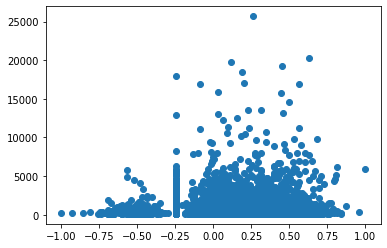

In [28]:
plt.scatter(df['score_ratio_norm'], df['answer_snippets'].str.len())

### Tokinization

The next step is to use the SnippetLexer to tokenize the code snippets. Snippets that are too short are right-padded while snippets that are too long are truncated.

In [29]:
# Turn the code snippets into tokens
lexer = SnippetLexer()

# def tokenize(snippet: str) -> Tuple[np.ndarray, LexerStatus]:
def tokenize(answer: pd.Series) -> Tuple[np.ndarray, LexerStatus]:
  snippet = answer['answer_snippets']
  toks, status = lexer.lex(snippet)
  toks = np.array([tok.type for tok in toks], dtype=str)

  # Right pad the tokens util they are toks_per_seq long
  pad_amount = toks_per_seq - len(toks)

  # Pad token sequences that are too short
  if pad_amount > 0:
    toks = np.pad(toks, (0, pad_amount), 'constant', constant_values='<PAD>')

  # Truncate ones that are too long
  elif pad_amount < 0:
    toks = toks[:toks_per_seq] 

  assert len(toks) == toks_per_seq, f'Expected {toks_per_seq} tokens, got {len(toks)}'
  return toks, status

# lexer_status is either 'success' or 'error'
df[['tokens', 'lexer_status']] = pd.DataFrame(df.apply(tokenize, axis=1).tolist(),
                                              index=df.index)

df.head(3)

,_id,answer_count,question_id,question_title,question_view_count,question_score,question_is_answered,question_has_highest_accepted_answer,answer_score,answer_snippets,answer_is_highest_scored,answer_url,score_ratio,score_ratio_norm,tokens,lexer_status
answer_id,,,,,,,,,,,,,,,,
5677564,5677347,10,5677347,Is there a better way to do C style error hand...,8380,11,True,False,3,"StatusCode FooBar(int a, int b, int c, bool* o...",False,https://stackoverflow.com/a/5677564,0.648499,0.171066,"[TYPEID, TYPEID, LPAREN, INT, TYPEID, COMMA, I...",success
54540847,4826311,15,4826311,How to sort a stack using only stack operations?,56220,26,True,True,0,class Program\n{\n static void Main(string[...,False,https://stackoverflow.com/a/54540847,0.000000,-0.246641,"[TYPEID, TYPEID, LBRACE, STATIC, VOID, TYPEID,...",success
500017,500006,17,500006,What is the purpose of anonymous { } blocks in...,7267,42,True,True,2,"int a=25;\nint b=30;\n{ //at this point, a=25,...",False,https://stackoverflow.com/a/500017,0.362460,-0.013176,"[INT, TYPEID, EQUALS, INT_CONST_DEC, SEMI, INT...",error


Snippets that failed to tokenize are likely invalid code. Therefore, they are removed.

In [30]:
# Remove snippets that failed to tokenize
df_start_len = len(df)
df = df[df['lexer_status'] == 'success']
df_filtered_len = len(df)
removed_percent = (df_start_len - df_filtered_len) / df_start_len * 100
print(f'Filtered out {removed_percent:.2f}% of the dataset because they failed tokenization.')

Filtered out 22.27% of the dataset because they failed tokenization.


In [31]:
vocab = np.append(np.asarray(lexer.tokens),
                   '<PAD>')

vocab_len = len(vocab)
print(f'vocab has {vocab_len} token types.')
vocab_dict: Dict[str, int] = dict()

for i, type in enumerate(vocab):
    vocab_dict[type] = i

print(np.sort(vocab))

vocab has 113 token types.
['<PAD>' 'AND' 'ANDEQUAL' 'ARROW' 'AUTO' 'BREAK' 'CASE' 'CHAR'
 'CHAR_CONST' 'COLON' 'COMMA' 'CONDOP' 'CONST' 'CONTINUE' 'DEFAULT'
 'DIVEQUAL' 'DIVIDE' 'DO' 'DOUBLE' 'ELLIPSIS' 'ELSE' 'ENUM' 'EQ' 'EQUALS'
 'EXTERN' 'FLOAT' 'FLOAT_CONST' 'FOR' 'GE' 'GOTO' 'GT' 'HEX_FLOAT_CONST'
 'ID' 'IF' 'INLINE' 'INT' 'INT_CONST_BIN' 'INT_CONST_CHAR' 'INT_CONST_DEC'
 'INT_CONST_HEX' 'INT_CONST_OCT' 'LAND' 'LBRACE' 'LBRACKET' 'LE' 'LNOT'
 'LONG' 'LOR' 'LPAREN' 'LSHIFT' 'LSHIFTEQUAL' 'LT' 'MINUS' 'MINUSEQUAL'
 'MINUSMINUS' 'MOD' 'MODEQUAL' 'NE' 'NOT' 'OFFSETOF' 'OR' 'OREQUAL'
 'PERIOD' 'PLUS' 'PLUSEQUAL' 'PLUSPLUS' 'PPHASH' 'PPPRAGMA' 'PPPRAGMASTR'
 'RBRACE' 'RBRACKET' 'REGISTER' 'RESTRICT' 'RETURN' 'RPAREN' 'RSHIFT'
 'RSHIFTEQUAL' 'SEMI' 'SHORT' 'SIGNED' 'SIZEOF' 'STATIC' 'STRING_LITERAL'
 'STRUCT' 'SWITCH' 'TIMES' 'TIMESEQUAL' 'TYPEDEF' 'TYPEID' 'U16CHAR_CONST'
 'U16STRING_LITERAL' 'U32CHAR_CONST' 'U32STRING_LITERAL' 'U8CHAR_CONST'
 'U8STRING_LITERAL' 'UNION' 'UNSIGNED' 'VOI

The models cannot operate on raw token types - they require a vector for input. To accomplish this, I one-hot encoded each token. The first step to doing this is converting each token type in the vocabulary into a numeric representation.

In [ ]:
def toks_to_nums(toks):
  return np.asarray([vocab_dict[tok] for tok in toks])

df['encoded_tokens'] = df['tokens'].apply(toks_to_nums)
df.head(2)

,_id,answer_count,question_id,question_title,question_view_count,question_score,question_is_answered,question_has_highest_accepted_answer,answer_score,answer_snippets,answer_is_highest_scored,answer_url,score_ratio,score_ratio_norm,tokens,lexer_status,encoded_tokens
answer_id,,,,,,,,,,,,,,,,,
5677564,5677347,10,5677347,Is there a better way to do C style error hand...,8380,11,True,False,3,"StatusCode FooBar(int a, int b, int c, bool* o...",False,https://stackoverflow.com/a/5677564,0.648499,0.171066,"[TYPEID, TYPEID, LPAREN, INT, TYPEID, COMMA, I...",success,"[39, 39, 86, 19, 39, 92, 19, 39, 92, 19, 39, 9..."
54540847,4826311,15,4826311,How to sort a stack using only stack operations?,56220,26,True,True,0,class Program\n{\n static void Main(string[...,False,https://stackoverflow.com/a/54540847,0.000000,-0.246641,"[TYPEID, TYPEID, LBRACE, STATIC, VOID, TYPEID,...",success,"[39, 39, 90, 28, 34, 39, 86, 39, 88, 89, 39, 8..."


# My Machine Learns but I Don't

Now that the data is ready, I can begin training the models. The first model is a Random Forest classifier operating on a Term Frequency/Inverse Document Frequency (TF/IDF) encoding. This is used as a control to compare the performance of the later models. The second model is a simple LSTM model, and the third one is a stacked LSTM model.

In [ ]:
# Fraction of the dataset (0-1 inclusive) to use for validation. The model will
# not train on this data, instead reserving it for checking its performance.
validation_split = 0.2

test = df.sample(frac=validation_split, random_state=rs)
train = df.drop(test.index, inplace=False)

## Control - TF/IDF with Random Forests


In [ ]:
def train_random_forest():
  # Use an identity function for tokinzation, as the input data is already
  # tokenized.
  ident = lambda x: x
 
  pipeline = Pipeline([('token-selector', ColumnSelector(cols=('tokens'),
                                                         drop_axis=True)),
                       ('tfidf', TfidfVectorizer(analyzer='word',
                                                 tokenizer=ident,
                                                 preprocessor=ident,
                                                 token_pattern=None
                                                 )),
                       ('rf', RandomForestRegressor(random_state=rs,
                                                    bootstrap=True))
  ])

  # Hyperparameters to tune
  param_grid = {
      'rf__n_estimators': [100, 150],
      'rf__max_depth': [10, 100],
      'rf__min_impurity_decrease': [0.01, 0.1]
  }

  # Tuning is performed with a grid search
  cv = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=3,
                    error_score='raise',
                    verbose=3)
  


  cv.fit(train, train['score_ratio_norm'])

  return cv

df_start_len = len(df)
rfr = train_random_forest() # Random Forest Regressor
df_end_len = len(df)

assert df_start_len == df_end_len, f'{df_start_len - df_end_len} rows were dropped during training'

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END rf__max_depth=10, rf__min_impurity_decrease=0.01, rf__n_estimators=100;, score=-0.075 total time=   4.6s
[CV 2/3] END rf__max_depth=10, rf__min_impurity_decrease=0.01, rf__n_estimators=100;, score=-0.078 total time=   4.6s
[CV 3/3] END rf__max_depth=10, rf__min_impurity_decrease=0.01, rf__n_estimators=100;, score=-0.078 total time=   4.6s
[CV 1/3] END rf__max_depth=10, rf__min_impurity_decrease=0.01, rf__n_estimators=150;, score=-0.075 total time=   4.8s
[CV 2/3] END rf__max_depth=10, rf__min_impurity_decrease=0.01, rf__n_estimators=150;, score=-0.078 total time=   4.8s
[CV 3/3] END rf__max_depth=10, rf__min_impurity_decrease=0.01, rf__n_estimators=150;, score=-0.078 total time=   4.8s
[CV 1/3] END rf__max_depth=10, rf__min_impurity_decrease=0.1, rf__n_estimators=100;, score=-0.075 total time=   4.6s
[CV 2/3] END rf__max_depth=10, rf__min_impurity_decrease=0.1, rf__n_estimators=100;, score=-0.078 total time=   4.5

### Random Forest Regression Results

In [ ]:
print(f'Best score: {rfr.best_score_}')
print(f'Error score: {rfr.error_score}')
print(f'Test Accuracy: {rfr.score(test, test["score_ratio_norm"]):.3f}')
print(f'Training Accuracy: {rfr.score(train, train["score_ratio_norm"]):.3f}')

rfr.best_params_

Best score: -0.07697715913609798
Error score: raise
Test Accuracy: -0.076
Training Accuracy: -0.077


{'rf__max_depth': 10,
 'rf__min_impurity_decrease': 0.01,
 'rf__n_estimators': 150}

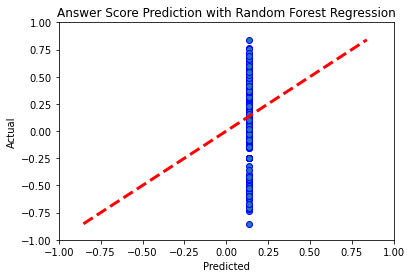

In [ ]:
y_test = test['score_ratio_norm']
y_predicted = rfr.predict(test)

fig, ax = plt.subplots()
ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax.set_title('Answer Score Prediction with Random Forest Regression')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()


Unfortunately, it seems the Random Forest was unable to find any patterns in the data and ended up just predicting the mean score ratio.

## LSTM v1

### Building and Setup

In [ ]:
# Number of passes of the training dataset the model will complete during
# gradient descent.
max_epochs = 100

# How many epochs to run after no improvement has occurred.
epoch_patience = 5

# Number of training samples to process before updating weights/biases. Used
# in stochastic gradient descent.
batch_size = 128

In [ ]:
# One-hot encode the token sequences
X = tf.one_hot(np.stack(df['encoded_tokens'].values),
               vocab_len,
               dtype=np.float32)


y = tf.convert_to_tensor(df['score_ratio_norm'])
assert X.shape[0] == y.shape[0]

print(f'Features shape: {X.shape}')
print(f'Predictions shape: {y.shape}')


Features shape: (7773, 1500, 101)
Predictions shape: (7773,)


### Training the Model

Hyperparameter tuning was performed with the [Hyperband](https://arxiv.org/abs/1603.06560) algorithm. The implementation of this algorithm was provided by [keras-tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [ ]:
def build_lstm_v1(hp: kt.HyperParameters) -> k.Sequential:
  hidden_layer_size = hp.Int('hidden_layer_size',
                             min_value=50,
                             max_value=200,
                             step=25)

  model: k.Sequential = keras.Sequential([
      layers.Input(shape=(toks_per_seq, vocab_len)),


      layers.LSTM(units=hidden_layer_size,
                  return_sequences=False,
                  name='tok-lstm-1'),

      layers.Dense(1, activation='tanh', name='output')
  ])

  use_amsgrad = hp.Boolean('use_amsgrad')
  learning_rate = hp.Float('step_size',
                           0.0001,
                           0.02,
                           sampling='log')
  optimizer = keras.optimizers.Adam(learning_rate, amsgrad=use_amsgrad)

  ################################################################################
  # Compile the model into a trainable neural network.
  # Model.compile() docs: https://keras.io/api/models/model_training_apis/#compile-method
  #
  # optimizer := Function used to minimize loss function via gradient descent.
  #              Full list of available optimizers may be found here: 
  #              https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
  # - sgd = Stochastic Gradient Descent (https://keras.io/api/optimizers/sgd/)
  #
  # loss := loss function to minimize
  # - mse = Mean Square Error (https://keras.io/api/losses/regression_losses/)
  #
  model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['accuracy'])
  return model

tuner = kt.Hyperband(build_lstm_v1,
                     objective='val_loss',
                     max_epochs=max_epochs,
                     factor=3,
                     seed=random_state,
                     directory='training2',
                     project_name='lstm_v1')

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project training2/lstm_v1/oracle.json
INFO:tensorflow:Reloading Tuner from training2/lstm_v1/tuner0.json
Search space summary
Default search space size: 3
hidden_layer_size (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 25, 'sampling': None}
use_amsgrad (Boolean)
{'default': False, 'conditions': []}
step_size (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.02, 'step': None, 'sampling': 'log'}


In [ ]:
def train(tuner: kt.Hyperband):
  # This callback saves the best model found during training to a file
  model_file = f'c-score-predictor-{time.time()}'
  checkpoint = ModelCheckpoint(
      filepath=model_file,
      save_weights_only=True,
      monitor='val_loss',
      mode='max',
      save_best_only=True)

  class LossHistory(Callback):
    def on_train_begin(self, logs={}):
      self.losses: List[float] = []
      self.val_losses: List[float] = []

    def on_batch_end(self, batch, logs={}):
      self.losses.append(logs.get('loss'))
      self.val_losses.append(logs.get('val_loss'))

  loss_history_callback = LossHistory()

  early_stopping_callback = EarlyStopping(monitor='loss',
                                          patience=epoch_patience,
                                          verbose=0,
                                          mode='auto')
  print(f'Started fitting at {str(time.localtime())}')

  tuner.search(X,
                y,
                epochs=max_epochs,
                validation_split=validation_split,
                batch_size=batch_size,
                verbose=1,
                use_multiprocessing=True,
                workers=6,
                callbacks=[checkpoint,
                            early_stopping_callback,
                            loss_history_callback,],
                shuffle=True)

In [ ]:
# Outputs for this cell are omitted
train(tuner)

In [ ]:
# Get the best model found during hyperparameter tuning
model: k.Sequential = tuner.get_best_models()[0]
tuner.results_summary()

Results summary
Results in training2/lstm_v1
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
hidden_layer_size: 75
use_amsgrad: True
step_size: 0.010251181475689626
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 4
tuner/round: 1
tuner/trial_id: 462f7bf4dea2954734aae885866e9815
Score: 0.07739584147930145
Trial summary
Hyperparameters:
hidden_layer_size: 100
use_amsgrad: False
step_size: 0.001205743203979354
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 4
tuner/round: 1
tuner/trial_id: 0bf19f3f81219d325b5d37e73bd00ac9
Score: 0.07741887122392654
Trial summary
Hyperparameters:
hidden_layer_size: 125
use_amsgrad: False
step_size: 0.011660828851377899
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 4
tuner/round: 1
tuner/trial_id: 140040edf78566697e1319ef13f45922
Score: 0.07746527343988419
Trial summary
Hyperparameters:
hidden_layer_size: 100
use_amsgrad: True
step_size: 0.0020072484410380053
tuner/epochs: 4
tuner/initial

### Results

Unfortunately, this model did not perform much better than the Random Forest Regressor. It also simply found the mean answer score ratio.

In [ ]:
y_predicted = model.predict(X)
amean = np.mean(y_predicted)
astd = np.std(y_predicted)

emean = np.mean(y)
estd = np.std(y)

print(f'Prediction mean: {amean:.2f}, standard dev: {astd:.2f}')
print(f'Expected mean: {emean:.2f}, standard dev: {estd:.2f}')

Prediction mean: 0.14, standard dev: 0.01
Expected mean: 0.14, standard dev: 0.28


Text(0, 0.5, 'Actual')

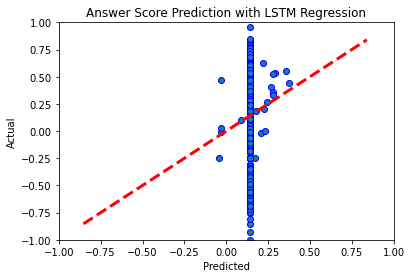

In [ ]:
# Graph the results
fig, ax = plt.subplots()
ax.scatter(y_predicted, y, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax.set_title('Answer Score Prediction with LSTM Regression')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## LSTM v2

This final model uses a stacked LSTM. The output sequence from the first LSTM layer is piped into the second layer, with a dropout layer inbetween them to reduce overfitting. Additionally, a dense layer is added before and after the LSTM stack.

In [ ]:
def build_lstm_v2(hp: kt.HyperParameters) -> k.Sequential:
  model: k.Sequential = keras.Sequential()
  model.add(layers.Input(shape=(toks_per_seq, vocab_len)))

  # A single dense layer between the input and the LTSMs
  model.add(layers.Dense(name='pre_lstm',
                          units=hp.Int('pre_lstm_units',
                                      min_value=5,
                                      max_value=100,
                                      step=5)))
    
  # This time, there are two LTSMs. Rather than just outputting the last tensor
  # in the sequence, the first one outputs _every_ token. This is fed into
  # another LTSM (with a droput layer between them to reduce overfitting)

  # LTSM 1
  layer_size1 = hp.Int('lstm1_hidden_layer_size',
                          min_value=50,
                          max_value=200,
                          step=25)
  model.add(layers.LSTM(units=layer_size1,
              return_sequences=True,
              name='tok-lstm-1'))
  
  # Intemediate dropout
  dropout_rate = hp.Float('inter_lstm_dropout_rate',
                        min_value=0.0,
                        max_value=0.02,
                        sampling='linear')
  model.add(layers.Dropout(dropout_rate))
  
  # LTSM 2
  layer_size2 = hp.Int('lstm2_hidden_layer1_size',
                            min_value=50,
                            max_value=200,
                            step=25)
  model.add(layers.LSTM(units=layer_size2,
              return_sequences=False,
              name='tok-lstm-2'))

  # Another dense layer after the LTSM stack for good measure
  model.add(layers.Dense(name='post_lstm',
                          units=hp.Int('post_lstm_units',
                                      min_value=5,
                                      max_value=100,
                                      step=5)))
  model.add(layers.Dense(1, activation='tanh', name='output'))

  # Optimizer setup
  use_amsgrad = hp.Boolean('use_amsgrad')
  learning_rate = hp.Float('optimizer_learning_rate',
                           0.0001,
                           0.02,
                           sampling='log')
  optimizer = keras.optimizers.Adam(learning_rate, amsgrad=use_amsgrad)

  # Compile the model and return the result
  model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['accuracy'])
  return model

tuner2 = kt.Hyperband(build_lstm_v2,
                     objective='val_loss',
                     max_epochs=max_epochs,
                     factor=3,
                     seed=random_state,
                     directory='training',
                     project_name='lstm_v2')

tuner2.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project training/lstm_v2/oracle.json
Search space summary
Default search space size: 8
pre_lstm_dense_layer_count (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 8, 'step': 1, 'sampling': None}
lstm1_hidden_layer_size (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 25, 'sampling': None}
inter_lstm_dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.02, 'step': None, 'sampling': 'linear'}
lstm2_hidden_layer1_size (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 25, 'sampling': None}
use_amsgrad (Boolean)
{'default': False, 'conditions': []}
optimizer_learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.02, 'step': None, 'sampling': 'log'}
pre_lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 100, 'step': 5, 'sampling': None}
post_lstm_u

### Training the Stacked LSTM

In [ ]:
# Output omitted
train(tuner2)

In [ ]:
model2: k.Sequential = tuner2.get_best_models()[0]
tuner2.results_summary()

Results summary
Results in training/lstm_v2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
pre_lstm_dense_layer_count: 5
lstm1_hidden_layer_size: 100
inter_lstm_dropout_rate: 0.016497094673848668
lstm2_hidden_layer1_size: 175
use_amsgrad: False
optimizer_learning_rate: 0.007332370781790844
pre_lstm_units: 45
post_lstm_units: 15
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.07736396044492722
Trial summary
Hyperparameters:
pre_lstm_dense_layer_count: 5
lstm1_hidden_layer_size: 100
inter_lstm_dropout_rate: 0.016497094673848668
lstm2_hidden_layer1_size: 175
use_amsgrad: False
optimizer_learning_rate: 0.007332370781790844
pre_lstm_units: 45
post_lstm_units: 15
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 4
tuner/round: 1
tuner/trial_id: 5fc8c54ab1d7d800a68197fc50d9f830
Score: 0.0773647129535675
Trial summary
Hyperparameters:
pre_lstm_dense_layer_count: 1
lstm1_hidden_layer_size: 175
inter_lstm_drop

### Results

Once again, this model was unable to detect patterns in the code snippets, only finding the mean score ratio.

In [ ]:
y_predicted = model2.predict(X)
amean = np.mean(y_predicted)
astd = np.std(y_predicted)

emean = np.mean(y)
estd = np.std(y)

print(f'Prediction mean: {amean:.2f}, standard dev: {astd:.2f}')
print(f'Expected mean: {emean:.2f}, standard dev: {estd:.2f}')

Prediction mean: 0.14, standard dev: 0.00
Expected mean: 0.14, standard dev: 0.28


Text(0, 0.5, 'Actual')

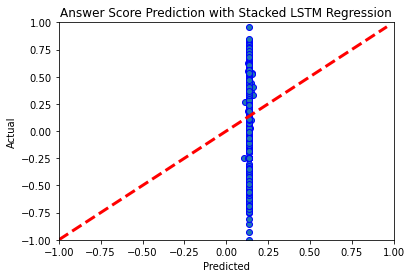

In [ ]:
y_test = df['score_ratio_norm']
fig, ax = plt.subplots()
ax.scatter(y_predicted, y, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax.set_title('Answer Score Prediction with Stacked LSTM Regression')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Conclusion

After training a Random Forest and two different LSTM models, I found that these models were unable to predict answer scores. I have several hypotheses for why this is the case.

My first hypothesis is that not enough information was present in the data for pattern detection, as only the token types were used. Better results may be achieved by encoding both the token's type and its value. My second hypothesis is that Random Forests and LSTMs are insufficiently complex to detect patterns in source code. Answering these questions requires further research, and may be an interesting project for further work.